<h1><center>Programming Exercise 5:<br>Regularized Linear Regression and Bias vs Variance</center></h1>

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io import loadmat 
from scipy.optimize import fmin_cg
import random

mpl.rcParams['figure.figsize'] = (10,6)

# 1. Regularized Linear Regression
- Implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir

## 1.1 Visualizing the Dataset

In [2]:
# Load data
data = loadmat('ex5data1.mat')
X,y = data['X'].flatten(),data['y'].flatten() # training set
Xval,yval = data['Xval'].flatten(),data['yval'].flatten() # cross-validation set
Xtest,ytest = data['Xtest'].flatten(),data['ytest'].flatten() # test set

# Add bias term and shape the design matrices
X = np.c_[np.ones_like(X),X]
Xval = np.c_[np.ones_like(Xval),Xval]
Xtest = np.c_[np.ones_like(Xtest),Xtest]

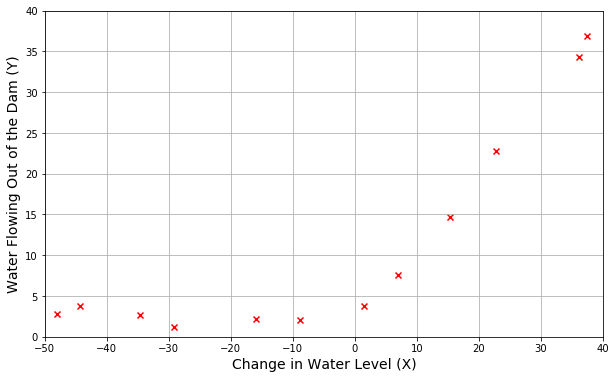

In [3]:
plt.figure()
plt.grid(True)
plt.scatter(X[:,1],y,marker='x',color='r')
plt.xlabel('Change in Water Level (X)',fontsize=14)
plt.ylabel('Water Flowing Out of the Dam (Y)',fontsize=14)
plt.xlim(-50,40)
plt.ylim(0,40)
plt.show()

## 1.2 Regularized Linear Regression Cost Function

In [4]:
def costFunction(theta,design,output,reg_param=0):
    '''
    Computes the cost function J = 1/2m*(X*Theta-Y)^T*(X*Theta-Y)+lambda/2m{Theta^T*Theta}
    for linear regression which is a function of Theta for a given sample set
    The regularization term is included only if a regularization parameter is passed in 
    X is the design matrix, Theta is the fit parameter vector, Y is the output vector of class labels
    and lambda is the regulatization parameter
    Returns the scalar J
    
    Parameters
    ----------
    theta: (n+1) fit parameter vector
    design: m by (n+1) design matrix
    output: m-dimensional output vector
    reg_param (optional): scalar, regularization parameter; default is 0
    
    Returns
    -------
    costJ: scalar, value of the cost function
    '''
    
    m = np.shape(design)[0] # sample size
    costJ = 1/(2*m)*((design @ theta) - output).T @ ((design @ theta) - output)
    costJ += reg_param/(2*m)*(theta[1:].T @ theta[1:]) # don't regularize the theta0 parameter

    return costJ

In [5]:
# Test
theta_init = np.array([1,1])
costFunction(theta_init,X,y,reg_param=1)

303.99319222026429

## 1.3 Regularized Linear Regression Gradient

In [6]:
def costFunctionGrad(theta,design,output,reg_param=0):
    '''
    Computes the gradient of the regularized linear regression cost function 
    in vectorized form:
    dJ/dTheta_j = 1/m{X^T*{(X*Theta)-Y}} + (lambda/m)Theta_j for j=0,1,..,n
    (Note: the 0th term does not get regularized)
    The regularization factor will only be added if a regularization parameter is passed in
    
    Parameters
    ----------
    theta: (n+1) fit parameter vector
    design: m by (n+1) design matrix
    output: m-dimensional output vector
    reg_param: scalar, regularization parameter; default is 0
    
    Returns
    ----------
    gradJ: (n+1) vector of gradient of cost function 
    '''
    m = np.shape(design)[0] # sample size
    gradJ = 1/m*(design.T @ ((design @ theta)-output))
    gradJ[1:] += theta[1:]*(reg_param/m) # regularize all other theta's but not theta_0
    
    return gradJ

In [7]:
# Test
costFunctionGrad(theta_init,X,y,reg_param=1)

array([ -15.30301567,  598.25074417])

## 1.4 Fitting Linear Regression

In [8]:
def trainLinearReg(design,output,reg_param=0):
    '''
    Trains linear regression given dataset: design and output
    including regularization parameter using fmin_cg
    Makes initial guess of zero-valued fit parameters
    
    Parameters
    ----------
    design: m by (n+1) design matrix
    output: m-dimensional output vector
    reg_param: scalar, regularization parameter; default is 0
    
    Returns
    ----------
    theta_opt: (n+1) optimal parameter vector
    '''
    
    # Initialize theta with zeros
    theta_init = np.zeros(np.shape(design)[1])
    # Optimize theta
    theta_opt = fmin_cg(costFunction,x0=theta_init,fprime=costFunctionGrad,\
                       args=(design,output,reg_param),maxiter=200,disp=False)
    return theta_opt

In [9]:
# Train with lambda = 0
theta_opt = trainLinearReg(X,y,reg_param=0)

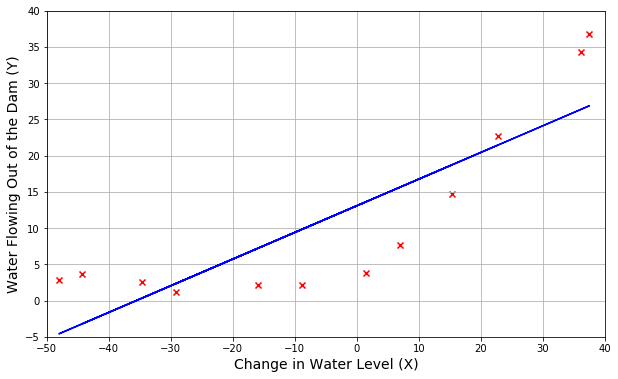

In [10]:
plt.figure()
plt.grid(True)
plt.scatter(X[:,1],y,marker='x',color='r') # training data
plt.plot(X[:,1],X @ theta_opt,'-b') # fit
plt.xlabel('Change in Water Level (X)',fontsize=14)
plt.ylabel('Water Flowing Out of the Dam (Y)',fontsize=14)
plt.xlim(-50,40)
plt.ylim(-5,40)
plt.show()

- Because of this implementation of linear regression is trying to fit a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta$ of such low dimension. Thus $\lambda=0$ 
- The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern

# 2. Bias-variance
- Plot training and test erros on a learning curve to diagnose bias-variance problems

## 2.1 Learning Curves
- Recall that the optimization is done with $n$ samples from 1 to $m$; we iterate through these values. The error calculation for the training set is done over the $n$ samples per iteration but it's done over all $m_{\text{train}}$ samples for the cross-validation set every time

In [11]:
def learningCurve(design,output,design_val,output_val,reg_param=0):
    '''
    Computes errors for training set and validation set as a function of 
    sample size which will range from 1 to m
    
    Parameters
    ----------
    design: m by (n+1) design matrix of training set
    output: m-dimensional output vector of training set
    design_val: m_train by (n+1) design matrix of cross validation set
    output_val: m_train-dimensional output vector of cross validation set
    reg_param: scalar, regularization parameter; default is 0
    
    Returns
    ----------
    error_train: m vector of training set errors
    error_val: m vector of cross validation set errors
    n_samples: m vector of # of samples used for error calculations
    '''
    
    m = np.shape(design)[0] # training sample size 
    n_samples = np.arange(1,m+1) # min number of samples is 1
    error_train = np.empty(n_samples.size) # allocate space for training set error
    error_val = np.empty_like(error_train) # allocate space for validation set error
    for ii_idx,ii_nsamples in enumerate(n_samples): # loop through training sample sizes
        # Train with first n samples and given reg parameter
        theta_opt = trainLinearReg(design[:ii_nsamples,:],output[:ii_nsamples],reg_param=reg_param)
        # Compute errors, recall that this is the same as the cost function
        # but with lambda = 0 so this has to be explicitly set
        error_train[ii_idx] = costFunction(theta_opt,design[:ii_nsamples,:],output[:ii_nsamples],reg_param=0)
        error_val[ii_idx] = costFunction(theta_opt,design_val,output_val,reg_param=0)
    return error_train,error_val,n_samples

- In this part we calculate the errors with no regularization ($\lambda=0$):

In [12]:
error_train,error_val,n_samples = learningCurve(X,y,Xval,yval,reg_param=0)

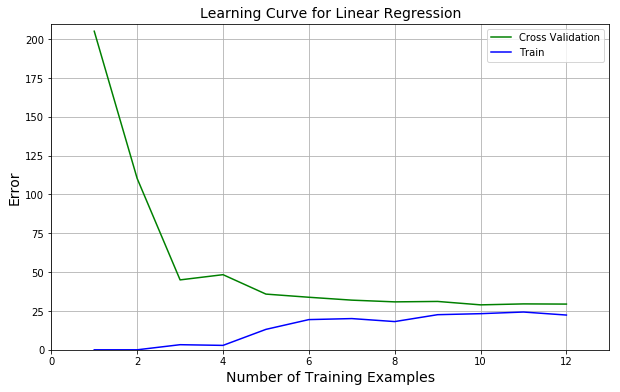

In [13]:
plt.figure()
plt.grid(True)
plt.plot(n_samples,error_val,'-g',label='Cross Validation')
plt.plot(n_samples,error_train,'-b',label='Train')
plt.xlim(0,13)
plt.ylim(0,210)
plt.legend(loc='upper right',fontsize='medium')
plt.xlabel('Number of Training Examples',fontsize=14)
plt.ylabel('Error',fontsize=14)
plt.title('Learning Curve for Linear Regression',fontsize=14)
plt.show()

- We see that both the traininig error and cross-validation error are high even as we increase the number of training samples
- This reflects a high bias in the model. That is, the linear regression model is too simple and is unable to fit our dataset well

# 3. Polynomial Regression
- The problem with the linear model above is that it's too simple for the data and results in underfitting (high bias). Here we will address this problem by adding more features
- For a feature $x$ (water level change in here) the polynomial regression the hypothesis will be of the form:

$$
\begin{equation}
\begin{split}
h_\theta(x) & = \theta_0+\theta_1\cdot (x)^1+\theta_2\cdot (x)^2+\ldots+\theta_p\cdot (x)^p\\
& = \theta_0+\theta_1\cdot x_1+\theta_2\cdot x_2+\ldots+\theta_p\cdot x_p
\end{split}
\end{equation}
$$

- Thus we will add features that are higher powers of the original feature $x$

In [14]:
def polyFeatures(design,p=1):
    '''
    Maps design matrix of one feature into the p-th power
    design matrix
    
    Parameters
    ----------
    design: m by 2 design matrix of training set 
    p: integer power of highest order polynomial, p > 1 or defaults to 1 as minimum
    
    Returns
    ----------
    pth_design: m by (p+1) design matrix with poly terms
    '''
    
    m = np.shape(design)[0] # training sample size
    pth_design = np.empty((m,p+1)) # allocate space for poly matrix
    pth_design[:,:2] = design[:,:2] # save the bias term and first power
    feature = design[:,1] # feature to compose polys from
    for ii_col in np.arange(2,p+1): # compute polys and save
        pth_design[:,ii_col] = np.power(feature,ii_col)
    return pth_design

In [15]:
# Up to p=8 for all three sets
p=8

X_poly = polyFeatures(X,p=p)
Xval_poly = polyFeatures(Xval,p=p)
Xtest_poly = polyFeatures(Xtest,p=p)

## 3.1 Learning Polynomial Regression
- Train polynomial regression using the linear regression cost function
- It turns out that if we run the training directly on the projected data it will not work well as the features would be badly scaled (e.g an example with $x=40$ will have a feature $x_8=40^8=6.5\times 10^{12}$). Thus we first apply feature normalization (wrt the training set):

In [16]:
means = np.mean(X_poly,axis=0) # ignore bias term of course, one mean per feature (column)
X_poly[:,1:] -= means[1:]
stds = np.std(X_poly,axis=0) # one std per feature (column)

# Apply to other two sets
Xval_poly[:,1:] -= means[1:]
Xtest_poly[:,1:] -= means[1:]
X_poly[:,1:] /= stds[1:]
Xval_poly[:,1:] /= stds[1:]
Xtest_poly[:,1:] /= stds[1:]

- Now train and get learning curve - without regularization:

In [17]:
# lambda = 0 
theta_opt = trainLinearReg(X_poly,y,reg_param=0)
error_train,error_val,n_samples = learningCurve(X_poly,y,Xval_poly,yval,reg_param=0)

- Plot:

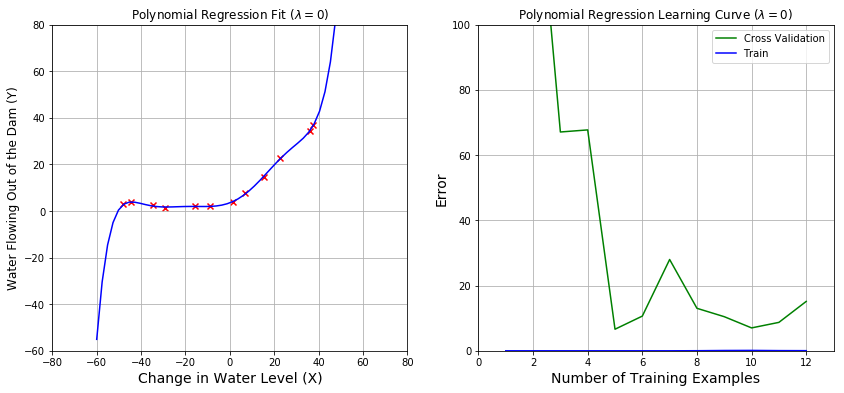

In [18]:
plt.figure(figsize=(14,6))

# Fit
plt.subplot(121)
plt.grid(True)
plt.scatter(X[:,1],y,marker='x',color='r') # training data
# Create a range and mean normalize it before plotting
xx_fit = np.c_[np.ones(50),np.linspace(-60,60,num=50)]
xx_fit_poly = polyFeatures(xx_fit,p=8)
xx_fit_poly[:,1:] -= means[1:]
xx_fit_poly[:,1:] /= stds[1:]
plt.plot(xx_fit[:,1],xx_fit_poly @ theta_opt,'-b') # fit
plt.xlabel('Change in Water Level (X)',fontsize=14)
plt.ylabel('Water Flowing Out of the Dam (Y)',fontsize=12)
plt.title(r'Polynomial Regression Fit ($\lambda=0$)',fontsize=12)
plt.xlim(-80,80)
plt.ylim(-60,80)

# Learning Curve
plt.subplot(122)
plt.grid(True)
plt.plot(n_samples,error_val,'-g',label='Cross Validation')
plt.plot(n_samples,error_train,'-b',label='Train')
plt.xlim(0,13)
plt.ylim(0,100)
plt.legend(loc='upper right',fontsize='medium')
plt.xlabel('Number of Training Examples',fontsize=14)
plt.ylabel('Error',fontsize=14)
plt.title(r'Polynomial Regression Learning Curve ($\lambda=0$)',fontsize=12)


plt.show()

- We can see that the polynomial fit is able to follow the datapoints very well - thus leading to a very low training error
- However, the fit is very complex and even drops off at the extremes. This is an indicator that this polynomial model is overfitting the training data and will not generalize well
- We can also see that the learning curve shows the same effect where the training error is low but the cross-validation error is high. There is a gap between the training and cross-validation errors, indicating a high variance problem

## 3.2 Optional Exercise: Adjusting the Regularization Parameter
- Observe how the regularization parameter affects the bias-variance of regularized polynomial regression
- First try $\lambda=1$:

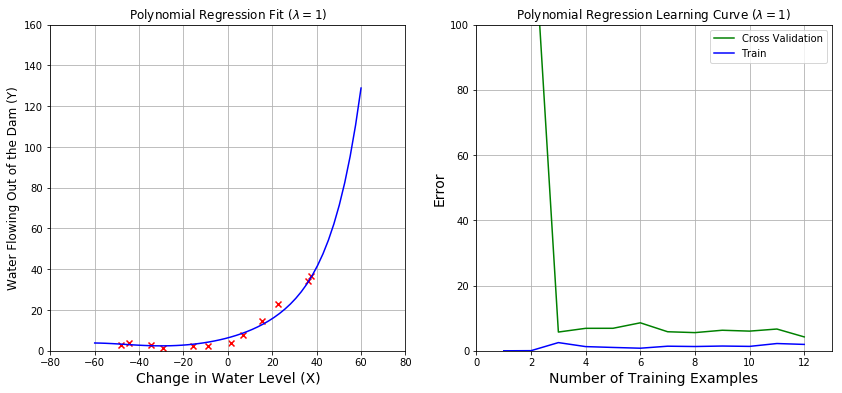

In [19]:
# Train
theta_opt = trainLinearReg(X_poly,y,reg_param=1)
# Compute errors
error_train,error_val,n_samples = learningCurve(X_poly,y,Xval_poly,yval,reg_param=1)

# Plot
plt.figure(figsize=(14,6))
# Fit
plt.subplot(121)
plt.grid(True)
plt.scatter(X[:,1],y,marker='x',color='r') # training data
# Create a range and mean normalize it before plotting
xx_fit = np.c_[np.ones(50),np.linspace(-60,60,num=50)]
xx_fit_poly = polyFeatures(xx_fit,p=8)
xx_fit_poly[:,1:] -= means[1:]
xx_fit_poly[:,1:] /= stds[1:]
plt.plot(xx_fit[:,1],xx_fit_poly @ theta_opt,'-b') # fit
plt.xlabel('Change in Water Level (X)',fontsize=14)
plt.ylabel('Water Flowing Out of the Dam (Y)',fontsize=12)
plt.title(r'Polynomial Regression Fit ($\lambda=1$)',fontsize=12)
plt.xlim(-80,80)
plt.ylim(0,160)
# Learning Curve
plt.subplot(122)
plt.grid(True)
plt.plot(n_samples,error_val,'-g',label='Cross Validation')
plt.plot(n_samples,error_train,'-b',label='Train')
plt.xlim(0,13)
plt.ylim(0,100)
plt.legend(loc='upper right',fontsize='medium')
plt.xlabel('Number of Training Examples',fontsize=14)
plt.ylabel('Error',fontsize=14)
plt.title(r'Polynomial Regression Learning Curve ($\lambda=1$)',fontsize=12)
plt.show()

- We see that the polynomial fit follows the data trend well and the learning curve shows that both the cross-validation and training error converge to a relatively low value
- The $\lambda=1$ polynomial regression model does not have either high-bias or high-variance problems and achieves a good trade-off
- Now with $\lambda=100$:

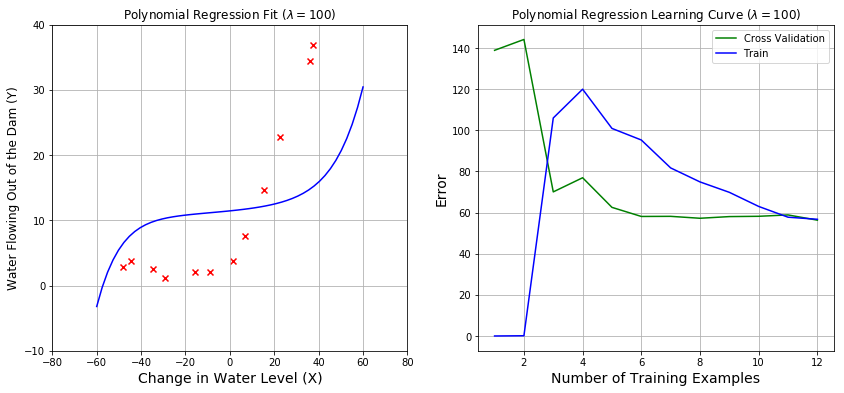

In [20]:
# Train
theta_opt = trainLinearReg(X_poly,y,reg_param=100)
# Compute errors
error_train,error_val,n_samples = learningCurve(X_poly,y,Xval_poly,yval,reg_param=100)

# Plot
plt.figure(figsize=(14,6))
# Fit
plt.subplot(121)
plt.grid(True)
plt.scatter(X[:,1],y,marker='x',color='r') # training data
# Create a range and mean normalize it before plotting
xx_fit = np.c_[np.ones(50),np.linspace(-60,60,num=50)]
xx_fit_poly = polyFeatures(xx_fit,p=8)
xx_fit_poly[:,1:] -= means[1:]
xx_fit_poly[:,1:] /= stds[1:]
plt.plot(xx_fit[:,1],xx_fit_poly @ theta_opt,'-b') # fit
plt.xlabel('Change in Water Level (X)',fontsize=14)
plt.ylabel('Water Flowing Out of the Dam (Y)',fontsize=12)
plt.title(r'Polynomial Regression Fit ($\lambda=100$)',fontsize=12)
plt.xlim(-80,80)
plt.ylim(-10,40)
# Learning Curve
plt.subplot(122)
plt.grid(True)
plt.plot(n_samples,error_val,'-g',label='Cross Validation')
plt.plot(n_samples,error_train,'-b',label='Train')
#plt.xlim(0,13)
#plt.ylim(0,100)
plt.legend(loc='upper right',fontsize='medium')
plt.xlabel('Number of Training Examples',fontsize=14)
plt.ylabel('Error',fontsize=14)
plt.title(r'Polynomial Regression Learning Curve ($\lambda=100$)',fontsize=12)
plt.show()

- In this model the polynomial fit does not follow the data well. There is too much regularization and thus underfitting
- Summary for polynomial regression thus far:
    - $\lambda=0$: Fits training set well but doesn't generalize
    - $\lambda=1$: Provides good fit and generalization
    - $\lambda=100$: Does not fit the training set or generalize

## 3.3 Selecting $\lambda$ Using a Cross Validation Set
- Implement an automated method to select the $\lambda$ parameter, i.e. use a cross-validation set to evaluate how good each $\lambda$ value is
- After selecting the best $\lambda$ value using the cross-validation set, we will evaluate the model on the test set to estimate how well the model will perform on actual unseen data

In [21]:
def validationCurve(design, output, design_val, output_val):
    '''
    Computes errors for training set and validation set as a function of 
    regularization parameter lambda for fixed values (internal)
    
    Parameters
    ----------
    design: m by (n+1) design matrix of training set
    output: m-dimensional output vector of training set
    design_val: m_train by (n+1) design matrix of cross validation set
    output_val: m_train-dimensional output vector of cross validation set
    
    Returns
    ----------
    error_train: m vector of training set errors
    error_val: m vector of cross validation set errors
    reg_params: vector of lambdas used for error calculations
    '''    
    reg_params = [0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10] # values of lambda to try 
    error_train = np.empty_like(reg_params) # allocate space for training errors
    error_val = np.empty_like(reg_params) # allocate space for cross-validation errors
    # Loop through values of lambda
    for ii_idx,ii_reg in enumerate(reg_params):
        # Optimize theta for some lambda
        theta_opt = trainLinearReg(design,output,reg_param=ii_reg)
        # Compute errors (lambda = 0 by definition here)
        error_train[ii_idx] = costFunction(theta_opt,design,output,reg_param=0)
        error_val[ii_idx] = costFunction(theta_opt,design_val,output_val,reg_param=0)
    return error_train,error_val,reg_params   

In [22]:
error_train,error_val,reg_params = validationCurve(X_poly,y,Xval_poly,yval)

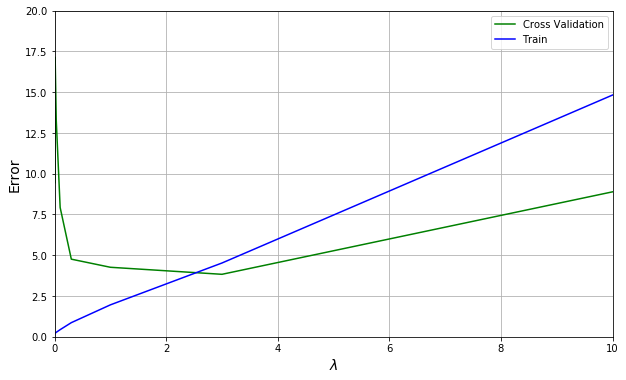

In [23]:
# Validation Curve 
plt.figure()
plt.grid(True)
plt.plot(reg_params,error_val,'-g',label='Cross Validation')
plt.plot(reg_params,error_train,'-b',label='Train')
plt.xlim(0,10)
plt.ylim(0,20)
plt.legend(loc='upper right',fontsize='medium')
plt.xlabel(r'$\lambda$',fontsize=14)
plt.ylabel('Error',fontsize=14)
plt.show()

- We can see from the plot that the best value for $\lambda$ is around 3; due to randomness in the training and validation splits of the dataset, the cross-validation error can sometimes be lower than the training error

## 3.4 Optional Exercise: Computing Test Set Error
- Now we test the final model (polynomial regression with $p=8$ powers and $\lambda=1$) on a test set that was not used in any part of training
- We compute the test error:

In [24]:
# Let's get the optimal theta for lambda=3
theta_opt = trainLinearReg(X_poly,y,reg_param=3)

# Compute test error
error_test = costFunction(theta_opt,Xtest_poly,ytest,reg_param=3)

print('\nTest error is: {}'.format(error_test))


Test error is: 9.522050043604104


## 3.5 Optional Exercise: Plotting Learning Curves with Randomly Selected Examples
- In practice, specially for small training sets, when you plot learning curves to debug your algorithms, it's often helpful to average across multiple sets of randomly selected examples to determine the training error and cross-validation error
- To determine the training error and cross-validation error for $i$ examples, first randomly select $i$ examples from the training set and $i$ examples from the cross-validation set. Then learn the optimal parameters $\theta$ using the randomly chosen training set and evaluate the errors in the randomly chosen sets. These steps are repeated multiple (e.g 50) times for fixed $i$ and the final error will be an average for $i$ examples
- Here we implement this strategy for computing learning curves in polynomial regression with $\lambda=0.01$

In [25]:
def learningCurveAverage(design,output,design_val,output_val,reg_param=0):
    '''
    Computes average errors for training set and validation set as a function of 
    sample size which will range from 1 to m. For a fixed sample size we choose 
    just as many random samples from respective sets for optimization and error
    calculation. The returned error is then an average for each sample size
    
    Parameters
    ----------
    design: m by (n+1) design matrix of training set
    output: m-dimensional output vector of training set
    design_val: m_train by (n+1) design matrix of cross validation set
    output_val: m_train-dimensional output vector of cross validation set
    reg_param: scalar, regularization parameter; default is 0
    
    Returns
    ----------
    error_train_avg: m vector of training set errors
    error_val_avg: m vector of cross validation set errors
    n_samples: m vector of # of samples used for error calculations
    '''
    
    m = np.shape(design)[0] # training sample size 
    n_samples = np.arange(1,m+1) # min number of samples is 1
    error_train_avg = np.empty(n_samples.size) # allocate space for training set error
    error_val_avg = np.empty_like(error_train_avg) # allocate space for validation set error
    for ii_idx,ii_nsamples in enumerate(n_samples): # loop through training sample sizes
        nsample_error_train = 0
        nsample_error_val = 0
        for ii_times in range(50): # repeat 50 times
            rand_ind = random.sample(range(m),ii_nsamples) # draw ii_nsamples random samples from indices of design matrix
            # Train with random samples and given reg parameter
            theta_opt = trainLinearReg(design[rand_ind,:],output[rand_ind],reg_param=reg_param)
            # Compute errors
            nsample_error_train += costFunction(theta_opt,design[rand_ind,:],output[rand_ind],reg_param=0)
            nsample_error_val += costFunction(theta_opt,design_val[rand_ind,:],output_val[rand_ind],reg_param=0)
        error_train_avg[ii_idx] = nsample_error_train/50 # average results and save
        error_val_avg[ii_idx] = nsample_error_val/50 # average results and save
        
    return error_train_avg,error_val_avg,n_samples

In [26]:
error_train_avg,error_val_avg,n_samples = learningCurveAverage(X_poly,y,Xval_poly,yval,reg_param=0.01)

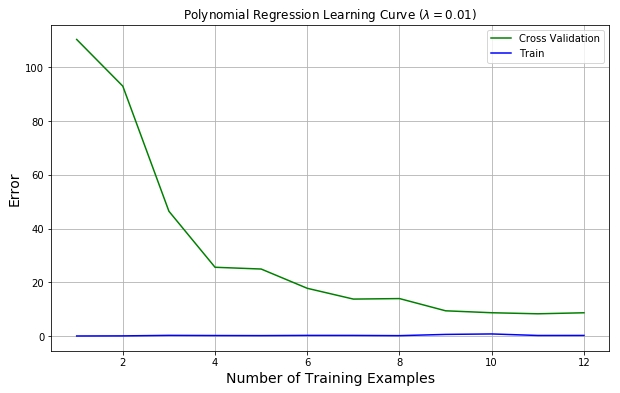

In [27]:
# Learning Curve
plt.figure()
plt.grid(True)
plt.plot(n_samples,error_val_avg,'-g',label='Cross Validation')
plt.plot(n_samples,error_train_avg,'-b',label='Train')
#plt.xlim(0,13)
#plt.ylim(0,100)
plt.legend(loc='upper right',fontsize='medium')
plt.xlabel('Number of Training Examples',fontsize=14)
plt.ylabel('Error',fontsize=14)
plt.title(r'Polynomial Regression Learning Curve ($\lambda=0.01$)',fontsize=12)
plt.show()

- We see the low error in the training set and a gap between the cross-validation error curve and the training set error curve which implies overfitting. Since we used a small $\lambda$ this makes sense